<a href="https://colab.research.google.com/github/mirpouya/TensorFlow-Tutorial/blob/main/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [65]:
dataset, dataset_info = tfds.load("malaria", with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

In [4]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

In [46]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * SIZE))
  val_dataset = dataset.skip(int(TRAIN_RATIO * SIZE)).take(int(VAL_RATIO * SIZE))
  test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO) * SIZE))

  return train_dataset, val_dataset, test_dataset

In [47]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [48]:
len(train_dataset), len(val_dataset), len(test_dataset)

(19290, 5511, 2756)

In [49]:
IM_SIZE = 224

def resize_rescale(image, label, img_size=IM_SIZE):
  return tf.image.resize(image, (img_size, img_size)) / 255.0 , label

In [50]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [51]:
train_dataset, val_dataset, test_dataset

(<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [52]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

<h2> <b> It is new from here </b> </h2>

<h2> <b> Data Augmentation </b> </h2>

In [53]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

In [54]:
# take one image from the dataset
original_image, label = next(iter(train_dataset))

In [55]:
original_image.shape

TensorShape([32, 224, 224, 3])

In [56]:
original_image[1].shape

TensorShape([224, 224, 3])

In [57]:
augmented_image = tf.image.flip_left_right(original_image)

In [58]:
augmented_image.shape

TensorShape([32, 224, 224, 3])

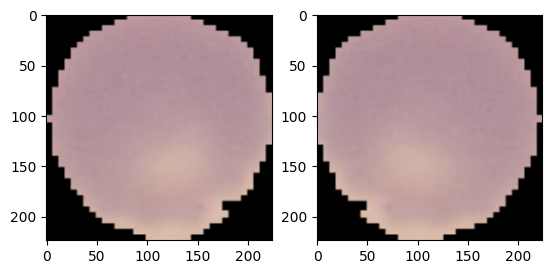

In [59]:
visualize(original_image[1], augmented_image[1])

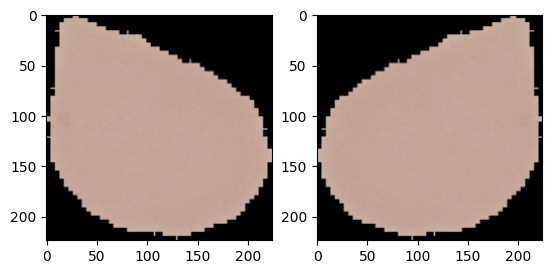

In [60]:
visualize(original_image[3], augmented_image[3])

In [61]:
augmented_image_1 = tf.image.random_flip_up_down(original_image)

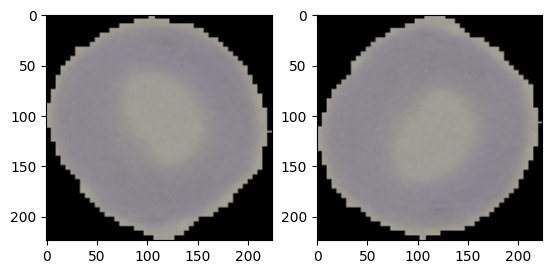

In [62]:
visualize(original_image[5], augmented_image_1[5])

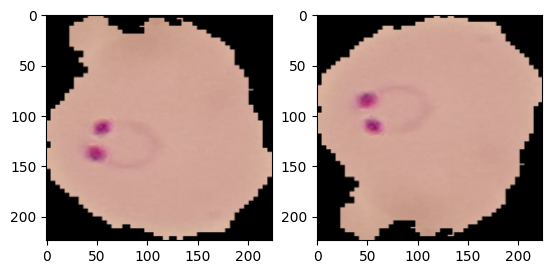

In [63]:
visualize(original_image[8], augmented_image_1[8])

<h3> <b> augment method </b> </h3>

In [40]:
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor=0.2)
  image = tf.image.flip_left_right(image)

  return image, label

In [29]:
augment_train_dataset = train_dataset.map(augment)
augment_val_dataset = val_dataset.map(augment)
augment_test_dataset = test_dataset.map(augment)

In [37]:
len(train_dataset), len(augment_train_dataset)

(603, 603)

In [38]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [39]:
augment_train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

<h3> <b> augmentation using keras layers </b> </h3>

In [41]:
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, BatchNormalization, MaxPool2D, Flatten, Layer, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [44]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [45]:
from matplotlib.hatch import HorizontalHatch
augment_layer = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501),),
    RandomFlip(mode="horizontal",),
])

In [64]:
def augment_func(image, label):
  return augment_layer(image, training=True), label

In [66]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [67]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [70]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(augment_func)
    .batch(BATCH_SIZE)
)